In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import custom libraries
import utils

In this notebook we build a model to forecast `US Wine Consumption (Mgal)`.

### Metrics
| Model | MAE | RSE | R-squared |
|:-------|-----|-----|-----------|
|Linear Regression (baseline)|24.582|805.432|0.680|
|Holt-Winters|23.656|726.824|0.718|
|ARIMA|**20.914**|**590.345**|**0.770**|
|DLM|24.234|774.672|0.695|

## Load Data

In [2]:
forecast_data = pd.read_csv("dataset/census_and_market_data.csv")
forecast_data.shape

(24, 22)

In [3]:
columns = ["Year", "US Wine Production (Mgal)", "Median Income", "Num Seniors", "Num w/ small children", "US Wine Sales Volume (Mgal)", "US Wine Consumption (Mgal)"]

In [4]:
forecast_data = forecast_data[columns].copy()

In [5]:
forecast_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         24 non-null     int64  
 1   US Wine Production (Mgal)    17 non-null     float64
 2   Median Income                24 non-null     int64  
 3   Num Seniors                  20 non-null     float64
 4   Num w/ small children        16 non-null     float64
 5   US Wine Sales Volume (Mgal)  23 non-null     float64
 6   US Wine Consumption (Mgal)   18 non-null     float64
dtypes: float64(5), int64(2)
memory usage: 1.4 KB


Augment `US Wine Sales Volume (Mgal)` data

In [6]:
consumption_data = pd.read_csv("dataset/wine_consumption.tsv", delimiter="\t")
consumption_data = consumption_data.rename(columns={"Total Wine (Mgal)": "US Wine Consumption (Mgal)"})
consumption_data.shape

(89, 4)

In [7]:
consumption_data["Year"].min()

1934

In [8]:
consumption_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            89 non-null     int64  
 1   Total Wine per Resident (gals)  89 non-null     float64
 2   US Wine Consumption (Mgal)      89 non-null     int64  
 3   Total Table Wine (Mgal)         89 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 2.9 KB


In [9]:
consumption_data = consumption_data[["Year", "US Wine Consumption (Mgal)"]]

In [10]:
data = pd.merge(forecast_data, consumption_data, on=["Year", "US Wine Consumption (Mgal)"], how="right").sort_values(by="Year")
data.shape

(89, 7)

In [11]:
data["Year"] = pd.to_datetime(data["Year"], format='%Y')
data = data.set_index("Year")
data.index.freq = 'AS-JAN' 
data = data.sort_index()
data.shape

(89, 6)

## Visualization, Stationarity and Correlations

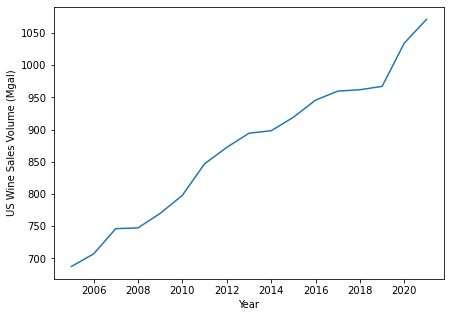

In [12]:
plt.figure(figsize=(7,5))
sns.lineplot(data=data, x=data.index, y="US Wine Sales Volume (Mgal)")
plt.savefig("us_wine_sales.png")

We observe that the data could be split into 3 periods of rougly 30-40 years.

In [13]:
utils.adf_test(data["US Wine Consumption (Mgal)"])

(0.3378590165673619, 0.9790162989994445)

In [14]:
utils.kpss_test(data["US Wine Consumption (Mgal)"])

C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:59: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries)


(1.4936894720747256, 0.01)

Overall, when going back to 1934 to 2022, the data is not stationary.

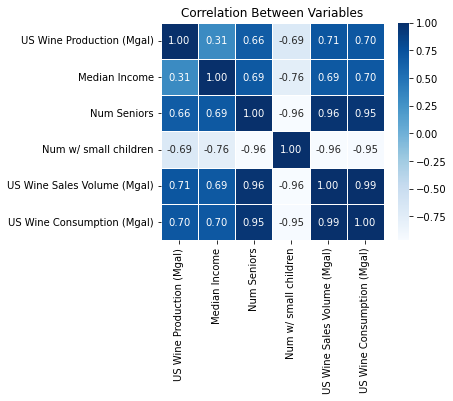

In [15]:
utils.visualize_correlation(utils.calculate_correlation(data), figsize=(5,4))

## Baseline

In [16]:
from sklearn.linear_model import Ridge, LinearRegression

In [17]:
baseline_data = data.iloc[-30:-1]["US Wine Consumption (Mgal)"].copy()

In [18]:
baseline_data = baseline_data.reset_index()
baseline_data["Year"] = baseline_data["Year"].dt.year

In [19]:
baseline_train, baseline_test = utils.split_dataset(baseline_data, test_size=0.2)
baseline_train.shape, baseline_test.shape

((23, 2), (6, 2))

In [20]:
ridge_reg = Ridge()
ridge_reg.fit(baseline_train.values[:,:-1], baseline_train.values[:,-1])

# Calculate metrics
baseline_preds = ridge_reg.predict(baseline_test.values[:,:-1])
baseline_mae, baseline_mse, baseline_r2 = utils.calculate_metrics(baseline_preds, baseline_test.values[:,-1])
print(f"MAE: {baseline_mae:.5f}, MSE: {baseline_mse:.5f}, R-squared: {baseline_r2:.5f}")

MAE: 28.20048, MSE: 952.08574, R-squared: 0.61473


<AxesSubplot:xlabel='Year', ylabel='US Wine Consumption (Mgal)'>

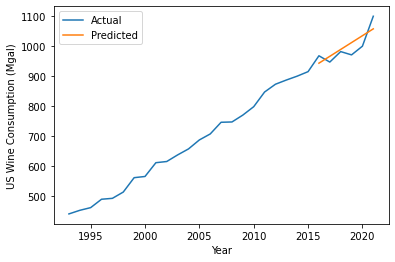

In [21]:
sns.lineplot(data=baseline_data, x="Year", y="US Wine Consumption (Mgal)", label="Actual")
sns.lineplot(x=baseline_test["Year"], y=baseline_preds, label="Predicted")

Cross-Validation

In [22]:
utils.stats_models_cv(model_name="lr", data=baseline_data, n_folds=3)

Mean MAE: 24.58205231163551
Mean MSE: 805.4328867989384
Mean R-squared: 0.6803399111794802
Train sizes: min=8, max=22
Test sizes: min=7, max=7

Metrics in non-stationary context


## Statistical Models

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pydlm import dlm, dynamic, trend

In [24]:
target = ["US Wine Consumption (Mgal)"]

### Holt-Winters Exponential Smoothing

In [25]:
hw_data = data.iloc[:-1][target].copy()

In [26]:
hw_train, hw_test = utils.split_dataset(hw_data, test_size=0.2)
hw_train.shape, hw_test.shape

((70, 1), (18, 1))

In [27]:
# Fit model
hw_model = ExponentialSmoothing(hw_train, trend='add', seasonal='add', seasonal_periods=10)
hw_model = hw_model.fit()

# Calculate metrics
forecast_hw = hw_model.forecast(steps=len(hw_test))
hw_mae, hw_mse, hw_r2 = utils.calculate_metrics(forecast_hw, hw_test)
print(f"MAE: {hw_mae:.5f}, MSE: {hw_mse:.5f}, R-squared: {hw_r2:.5f}")

MAE: 22.70619, MSE: 955.20949, R-squared: 0.93426


<AxesSubplot:xlabel='Year', ylabel='US Wine Consumption (Mgal)'>

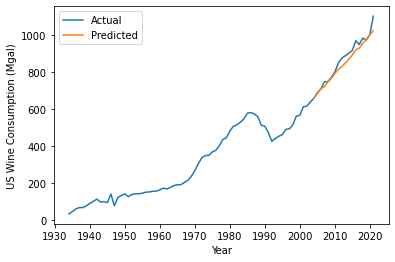

In [28]:
sns.lineplot(data=hw_data, x=hw_data.index, y=target[0], label="Actual")
sns.lineplot(x=forecast_hw.index, y=forecast_hw.values, label="Predicted")

Cross-Validation

In [29]:
hw_params = {"seasonal_periods": "half"}
utils.stats_models_cv(model_name="holt-winters", data=hw_data.iloc[-29:], params=hw_params, n_folds=3)

Mean MAE: 26.42330169294031
Mean MSE: 916.0908826459521
Mean R-squared: 0.6356457275237715
Train sizes: min=8, max=22
Test sizes: min=7, max=7

Metrics in non-stationary context


### ARIMA

In [30]:
arima_data = data.iloc[:-1][target].copy()

In [31]:
arima_train, arima_test = utils.split_dataset(arima_data, test_size=0.2)
arima_train.shape, hw_test.shape

((70, 1), (18, 1))

In [32]:
# Train model
p, d, q = 1, 2, 1
arima_model = ARIMA(arima_train, order=(p, d, q))
arima_model = arima_model.fit()

# Calculate metrics
forecast_arima = arima_model.forecast(steps=len(arima_test))
arima_mae, arima_mse, arima_r2 = utils.calculate_metrics(forecast_arima, arima_test)
print(f"MAE: {arima_mae:.5f}, MSE: {arima_mse:.5f}, R-squared: {arima_r2:.5f}")

MAE: 42.64921, MSE: 2593.75452, R-squared: 0.82150


<AxesSubplot:xlabel='Year', ylabel='US Wine Consumption (Mgal)'>

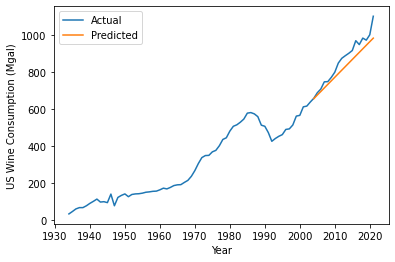

In [33]:
sns.lineplot(data=arima_data, x=arima_data.index, y=target[0], label="Actual")
sns.lineplot(x=forecast_arima.index, y=forecast_arima.values, label="Predicted")

Cross-Validation

In [34]:
arima_params = {"p": 1, "d": 2, "q": 1}
utils.stats_models_cv(model_name="arima", data=arima_data.iloc[-29:], params=arima_params, n_folds=3)

Mean MAE: 20.914036068212624
Mean MSE: 590.3450254992346
Mean R-squared: 0.7702587821706811
Train sizes: min=8, max=22
Test sizes: min=7, max=7

Metrics in non-stationary context


C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Dynamic Linear Models (DLM)

#### Without additional features
We assume a linearity of the data and we only use the target variable.

In [35]:
dlm_data = data.iloc[:-1][target].copy()#iloc[-30:-1][target].copy()

In [36]:
dlm_train, dlm_test = utils.split_dataset(dlm_data, test_size=0.2)
dlm_train.shape, dlm_test.shape

((70, 1), (18, 1))

In [37]:
# Fit model on train data
dlm_model = dlm(dlm_train.values)
# Given the data is linear, we add a linear trend component
dlm_model = dlm_model + trend(degree=1, discount=0.4)
dlm_model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [38]:
# Forecast the next steps
forecast_dlm = dlm_model.predictN(N=len(dlm_test))[0]

In [39]:
dlm_mae, dlm_mse, dlm_r2 = utils.calculate_metrics(forecast_dlm, dlm_test)
print(f"MAE: {dlm_mae:.5f}, MSE: {dlm_mse:.5f}, R-squared: {dlm_r2:.5f}")

MAE: 31.44165, MSE: 1578.72735, R-squared: 0.89135


<AxesSubplot:xlabel='Year', ylabel='US Wine Consumption (Mgal)'>

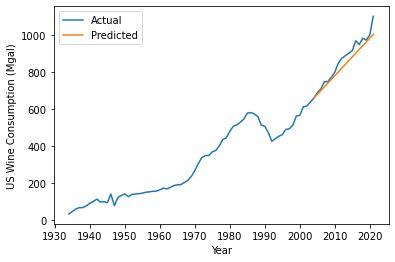

In [40]:
sns.lineplot(data=dlm_data, x=dlm_data.index, y=target[0], label="Actual")
sns.lineplot(x=dlm_test.index, y=forecast_dlm, label="Predicted")

Cross-validation

In [41]:
dlm_params = {"discount": 0.95, "features_data": "linear"}
utils.stats_models_cv(model_name="dlm", data=dlm_data.iloc[-30:], params=dlm_params, n_folds=3)

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Mean MAE: 24.234349598117507
Mean MSE: 774.6725307912753
Mean R-squared: 0.6955018258720508
Train sizes: min=9, max=23
Test sizes: min=7, max=7

Metrics in non-stationary context


## Use Stationary Data

In [42]:
stationary_data = data.copy()
stationary_data.shape

(89, 6)

In [43]:
stationary_data["US Wine Consumption (Mgal)"] = utils.make_stationary(df=stationary_data, column_name="US Wine Consumption (Mgal)", lag=1)
stationary_data = stationary_data.iloc[1:]
stationary_data.shape

(88, 6)

In [44]:
utils.adf_test(stationary_data["US Wine Consumption (Mgal)"], verbose=1)

ADF Statistic: -3.272
p-value: 0.016

ADF test: Data is stationary


(-3.2723181856447514, 0.016162116316611498)

<AxesSubplot:xlabel='Year', ylabel='US Wine Consumption (Mgal)'>

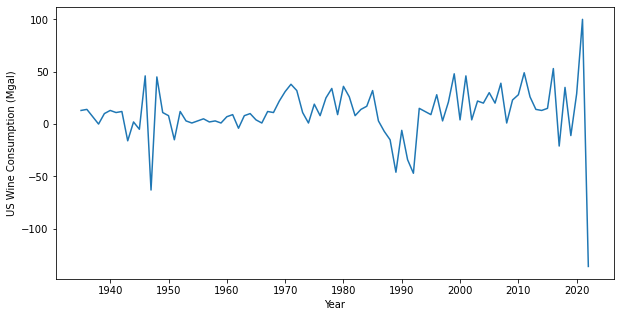

In [45]:
plt.figure(figsize=(10,5))
sns.lineplot(data=stationary_data, x=stationary_data.index, y="US Wine Consumption (Mgal)")

In [46]:
hw_params = {"seasonal_periods": "half"}
utils.stats_models_cv(model_name="holt-winters", data=hw_data.iloc[:], stationary_column="US Wine Consumption (Mgal)", params=hw_params, n_folds=3)

'column' made stationary with lag=1


C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed

Mean MAE: 22.537924662974714
Mean MSE: 899.5218222916675
Mean R-squared: -2.2124938868306994
Train sizes: min=24, max=66
Test sizes: min=21, max=21

Metrics in non-stationary context
Mean MAE: 112.7443972093962
Mean MSE: 29063.771980530786
Mean R-squared: -5.87978096130448


In [47]:
arima_params = {"p": 1, "d": 2, "q": 1}
utils.stats_models_cv(model_name="arima", data=data.iloc[:-1][target], stationary_column="US Wine Consumption (Mgal)", params=arima_params, n_folds=3)

'column' made stationary with lag=1
Mean MAE: 18.327333892931833
Mean MSE: 624.2967949321169
Mean R-squared: -0.8864905801860038
Train sizes: min=24, max=66
Test sizes: min=21, max=21

Metrics in non-stationary context
Mean MAE: 94.32847798450689
Mean MSE: 21514.23027781675
Mean R-squared: -6.011461266884676


C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed

In [48]:
dlm_params = {"discount": 0.95, "features_data": "linear"}
utils.stats_models_cv(model_name="dlm", data=data.iloc[:-1][target], stationary_column="US Wine Consumption (Mgal)", params=dlm_params, n_folds=3)

'column' made stationary with lag=1
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Mean MAE: 20.7049653180534
Mean MSE: 754.6904251624596
Mean R-squared: -0.9322431155401788
Train sizes: min=24, max=66
Test sizes: min=21, max=21

Metrics in non-stationary context
Mean MAE: 144.8234364059767
Mean MSE: 35352.46404100446
Mean R-squared: -8.596473661537678


C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed_column = pd.Series(index=range(len(differenced_data)))
C:\Users\ngoum\Documents\coding\fleming_wilde\machine_learning\ml_test_project\french_winery_ml_project\utils.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  back_transformed